#### 필수과제
- prophet에 대한 파라미터를 모두 다 정리해주시고
- 실제 파라미터를 넣어서 예측값을 고도화 시켜주세요
- 모두 예측값을 만들어서 실제값과 비교해서 오차율을 계산해주세요. (오차율계산법 확인)
- 기본으로만 사용했던 prophet 예측값과, 실제 파라미터를 튜닝했을 때 예측값을 비교하고
- 어떤 파라미터가 실제값에 영향을 주었는지 정리하고 발표해주세요!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
filepath = '/content/drive/MyDrive/Colab Notebooks/BDAA 학회/데이터셋/sales_data.csv'

In [3]:
import pandas as pd

In [4]:
sales = pd.read_csv(filepath, encoding = 'latin')
sales.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### sales 데이터 전처리

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
new_sales = sales.copy()

In [7]:
new_sales['InvoiceDate'] = pd.to_datetime(new_sales['InvoiceDate'])

In [8]:
new_sales = new_sales[new_sales['Country'] == 'United Kingdom']

In [9]:
new_sales = new_sales.set_index('InvoiceDate').resample('D').sum()

In [10]:
holiday = new_sales[new_sales['Quantity'] == 0].index # 뒤에서 holiday 파라미터에 적용하기 위해 생성

In [11]:
holiday

DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
               '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
               '2011-01-02', '2011-01-03', '2011-01-08', '2011-01-15',
               '2011-01-22', '2011-01-29', '2011-02-05', '2011-02-12',
               '2011-02-19', '2011-02-26', '2011-03-05', '2011-03-12',
               '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
               '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
               '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
               '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
               '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
               '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
               '2011-08-20', '2011-08-27', '2011-08-29', '2011-09-03',
      

In [12]:
new_sales = new_sales[new_sales['Quantity'] > 0]
new_sales = new_sales[new_sales['UnitPrice'] > 0]

In [13]:
new_sales['Tot_price'] = new_sales['Quantity'] * new_sales['UnitPrice'] # 예측할 총 가격 컬럼 생성

In [14]:
new_sales.head(5)

,Quantity,UnitPrice,CustomerID,Tot_price
InvoiceDate,,,,
2010-12-01,23949,12428.08,28785059.0,2.976401e+08
2010-12-02,20873,6752.48,32725238.0,1.409445e+08
2010-12-03,10439,10313.01,14644964.0,1.076575e+08
2010-12-05,13604,7106.07,38403047.0,9.667098e+07
2010-12-06,20669,17357.95,30579854.0,3.587715e+08


#### prophet 모델 적합을 위한 전처리

In [15]:
pp_sales = new_sales.reset_index(drop = False) # 인덱스를 풀어주어야 함

In [16]:
pp_sales = pp_sales[['InvoiceDate', 'Tot_price']] # 총 가격을 예측

In [17]:
pp_sales = pp_sales.rename(columns = {'InvoiceDate' : 'ds', 'Tot_price' : 'y'}) # prophet 모델을 위해 컬럼 명 변경

In [18]:
pp_sales.head(5)

,ds,y
0,2010-12-01,2.976401e+08
1,2010-12-02,1.409445e+08
2,2010-12-03,1.076575e+08
3,2010-12-05,9.667098e+07
4,2010-12-06,3.587715e+08


In [19]:
import seaborn as sns

<AxesSubplot:xlabel='ds', ylabel='y'>

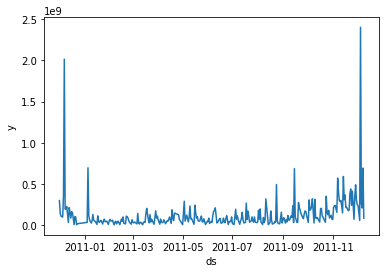

In [20]:
sns.lineplot(data = pp_sales, x = 'ds', y = 'y')

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_input, test_input= train_test_split(pp_sales, shuffle = False, test_size = 0.1)
# train_test_split 함수의 shuffle 효과없이 train과 test로 분류

In [23]:
display(train_input)
display(test_input)

,ds,y
0,2010-12-01,2.976401e+08
1,2010-12-02,1.409445e+08
2,2010-12-03,1.076575e+08
3,2010-12-05,9.667098e+07
4,2010-12-06,3.587715e+08
...,...,...
267,2011-10-30,1.199745e+08
268,2011-10-31,7.051174e+07
269,2011-11-01,6.779456e+07
270,2011-11-02,2.170504e+08


,ds,y
272,2011-11-04,2.380560e+08
273,2011-11-06,1.548807e+08
274,2011-11-07,5.703903e+08
275,2011-11-08,4.060113e+08
276,2011-11-09,2.980074e+08
277,2011-11-10,2.864228e+08
278,2011-11-11,2.988797e+08
279,2011-11-13,1.475289e+08
280,2011-11-14,5.901913e+08
281,2011-11-15,3.082268e+08


#### prophet 적합 1

In [24]:
from prophet import Prophet

In [25]:
prophet = Prophet()

In [26]:
prophet.fit(train_input) # 파라미터 튜닝 없이 학습

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/o9oej9_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/e7lgxk9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3414', 'data', 'file=/tmp/tmpbodtrnmg/o9oej9_u.json', 'init=/tmp/tmpbodtrnmg/e7lgxk9p.json', 'output', 'file=/tmp/tmpbodtrnmg/prophet_modelmy_8e0dh/prophet_model-20230226125852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:58:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:58:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
import pandas.tseries.offsets
from pandas.tseries.offsets import Day, Hour, Second

In [28]:
test_input['ds'].max() - test_input['ds'].min() + Day(1) # 며칠을 예측해야 하는지

Timedelta('36 days 00:00:00')

In [29]:
future = prophet.make_future_dataframe(periods = 36) # 36일 예측

In [30]:
forecast = prophet.predict(future) # 예측 실행

In [31]:
preds = forecast[['ds', 'yhat']][274:] # 예측한 값
real = pp_sales[274:] # 실제 값

In [32]:
df_preds_real = pd.merge(preds, real, how = 'outer').fillna(0)
# 오차를 계산하기 위해 두 데이터프레임을 합치고 결측치는 0으로 처리

In [33]:
df_preds_real.tail(5)

,ds,yhat,y
29,2011-12-05,1.565390e+08,2.402880e+09
30,2011-12-06,1.943078e+08,2.586585e+08
31,2011-12-07,1.528481e+08,2.071209e+08
32,2011-12-08,1.625241e+08,6.925605e+08
33,2011-12-09,1.263954e+08,8.307642e+07


In [37]:
import numpy as np
df_preds_real['error'] = df_preds_real['y'] - df_preds_real['yhat']
df_preds_real['error_rate'] = (np.abs(df_preds_real['error']) * 100)/df_preds_real['y']
 # 일반적인 오차와 오차율 계산법으로 계산

In [38]:
print(np.mean(df_preds_real['error']))
print(np.mean(df_preds_real['error_rate'])) # 오차와 오차율의 평균을 비교하며 모델을 비교

174391653.58060738
inf


In [39]:
# MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_preds_real['y'], df_preds_real['yhat'])

229424741.3674394

In [40]:
# MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(df_preds_real['y'], df_preds_real['yhat'])

1.905691754327777e+17

In [41]:
# RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_preds_real['y'], df_preds_real['yhat'])
np.sqrt(mse)

436542295.1247424

#### prophet 적합 2

#### Growth 파라미터
- linear, logistic
- logistic 인 경우 y데이터에 상한과 하한을 반드시 설정해주어야함 (cap, floor)
- test 데이터도 상한, 하한값 설정 가능


In [42]:
def outliers_iqr(data):
  q1, q3 = np.percentile(data, [25, 75])
  iqr = q3 - q1
  lower_bound = q1 - (iqr * 1.5)
  upper_bound = q3 + (iqr * 1.5)
  return np.where((data > upper_bound)|(data < lower_bound)), lower_bound, upper_bound
# logistic 으로 적합시키지 위해 이상치 존재여부와 상한, 하한 탐색을 위한 사용자 정의 함수

In [43]:
outliers_iqr(train_input['y'])

((array([  0,   4,   5,  21, 117, 123, 128, 180, 201, 211, 227, 229, 233,
         244, 248, 250, 262, 271]),), -81790547.32875001, 228837395.72125)

In [44]:
train_input['cap'] =  228837395.72125
train_input['floor'] = 0 # 훈련데이터에 상한과 하한을 설정

In [45]:
prophet = Prophet(growth = 'logistic')

In [46]:
prophet.fit(train_input)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/v9s69lld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/5hbr0y6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47676', 'data', 'file=/tmp/tmpbodtrnmg/v9s69lld.json', 'init=/tmp/tmpbodtrnmg/5hbr0y6h.json', 'output', 'file=/tmp/tmpbodtrnmg/prophet_model_3_wfqzw/prophet_model-20230226125920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [47]:
future = prophet.make_future_dataframe(periods = 36)

In [48]:
future['cap'] =  228837395.72125
future['floor'] = 0 # 예측하는 값에도 역시 상한과 하한 설정

In [49]:
forecast = prophet.predict(future)

In [50]:
preds = forecast[['ds', 'yhat']][274:]
real = pp_sales[274:]
df_preds_real = pd.merge(preds, real, how = 'outer').fillna(0)

In [51]:
df_preds_real['error'] = df_preds_real['y'] - df_preds_real['yhat']
df_preds_real['error_rate'] = (np.abs(df_preds_real['error']) * 100)/df_preds_real['y']

In [52]:
print(np.mean(df_preds_real['error']))
print(np.mean(df_preds_real['error_rate']))

116657428.77962433
inf


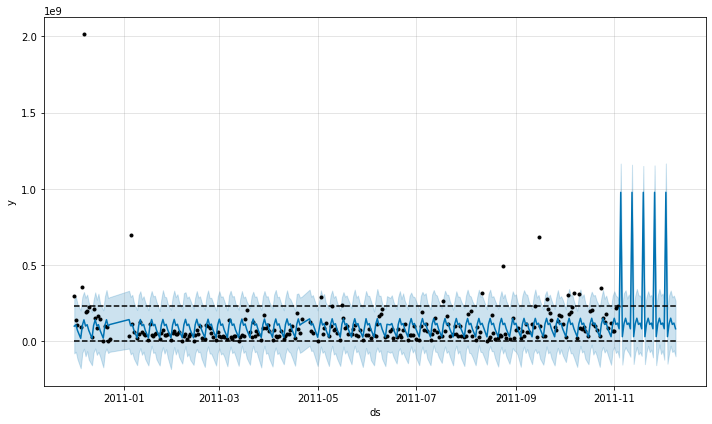

In [53]:
fig = prophet.plot(forecast)

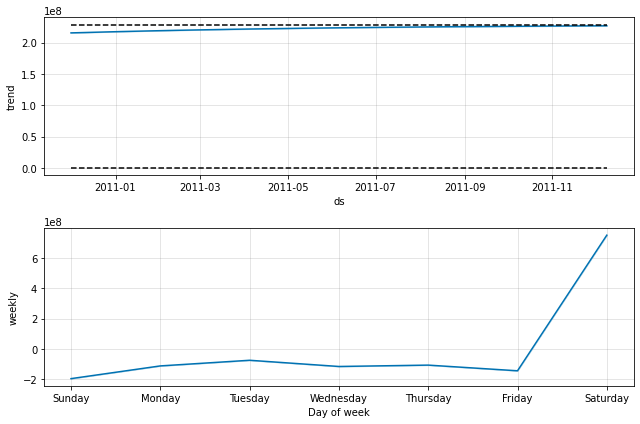

In [54]:
fig = prophet.plot_components(forecast)

#### prophet 적합 3

#### Trend 파라미터
- changepoint_prior_scale (추정민감도) : 높을수록 민감
- changepoints (cp가 발생하는 시점들의 list)
- n_changepoints (cp의 수)

In [55]:
train_input['cap'] =  228837395.72125
train_input['floor'] = 0

prophet = Prophet(growth = 'logistic', 
                  changepoint_prior_scale = 0.03)

In [56]:
prophet.fit(train_input)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/qs81y5dc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/9_9h9vx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15335', 'data', 'file=/tmp/tmpbodtrnmg/qs81y5dc.json', 'init=/tmp/tmpbodtrnmg/9_9h9vx3.json', 'output', 'file=/tmp/tmpbodtrnmg/prophet_modelwivy8x0j/prophet_model-20230226125920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
future = prophet.make_future_dataframe(periods = 36)

In [58]:
future['cap'] =  228837395.72125
future['floor'] = 0

forecast = prophet.predict(future)

In [59]:
preds = forecast[['ds', 'yhat']][274:]
real = pp_sales[274:]
df_preds_real = pd.merge(preds, real, how = 'outer').fillna(0)

In [60]:
df_preds_real['error'] = df_preds_real['y'] - df_preds_real['yhat']
df_preds_real['error_rate'] = (np.abs(df_preds_real['error']) * 100)/df_preds_real['y']

print(np.mean(df_preds_real['error']))
print(np.mean(df_preds_real['error_rate']))

116464262.6799611
inf


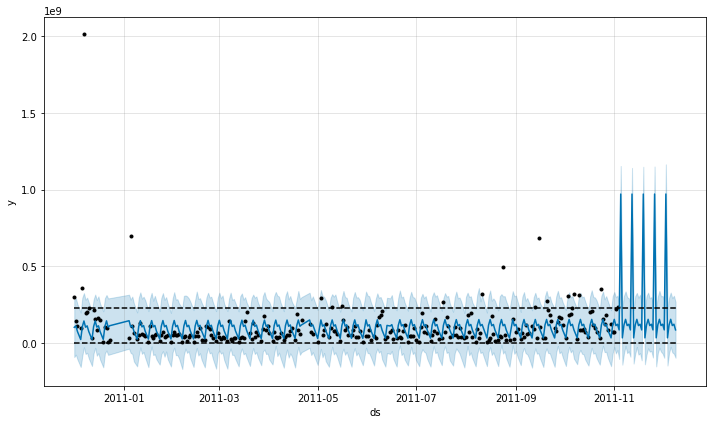

In [61]:
fig = prophet.plot(forecast)

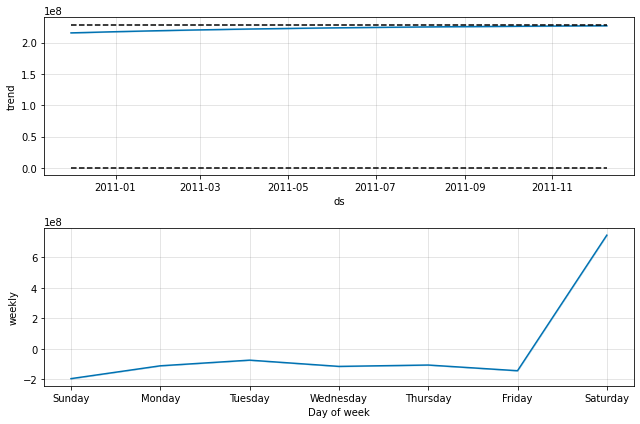

In [62]:
fig = prophet.plot_components(forecast)

#### prophet 적합 4

#### Seasonality 파리미터
- yearly_seasonality (연계절성)
- weekly_seasonality (주계절성)
- daily_seasonality (일계절성)
- seasonality_prior_scale (계절성 민감도)
- add_seasonality (계절성 추가) : 월 계절성 추가 가능
- seasonality_mode : addtive (등분산) or multiplicative(이분산)

In [63]:
train_input['cap'] =  228837395.72125
train_input['floor'] = 0

prophet = Prophet(growth = 'logistic', 
                  changepoint_prior_scale = 0.03,
                  seasonality_mode = 'additive',
                  seasonality_prior_scale = 10,
                  yearly_seasonality = True,
                  weekly_seasonality = 'auto',
                  daily_seasonality = 'auto')

# prophet.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)

In [64]:
prophet.fit(train_input)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/fzwd49pp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/84nphjyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49038', 'data', 'file=/tmp/tmpbodtrnmg/fzwd49pp.json', 'init=/tmp/tmpbodtrnmg/84nphjyd.json', 'output', 'file=/tmp/tmpbodtrnmg/prophet_modelhv480jan/prophet_model-20230226125921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [65]:
future = prophet.make_future_dataframe(periods = 36)

In [66]:
future['cap'] =  228837395.72125
future['floor'] = 0

forecast = prophet.predict(future)

In [67]:
preds = forecast[['ds', 'yhat']][274:]
real = pp_sales[274:]
df_preds_real = pd.merge(preds, real, how = 'outer').fillna(0)

In [68]:
df_preds_real['error'] = df_preds_real['y'] - df_preds_real['yhat']
df_preds_real['error_rate'] = (np.abs(df_preds_real['error']) * 100)/df_preds_real['y']

print(np.mean(df_preds_real['error']))
print(np.mean(df_preds_real['error_rate']))

-84748050.3334163
inf


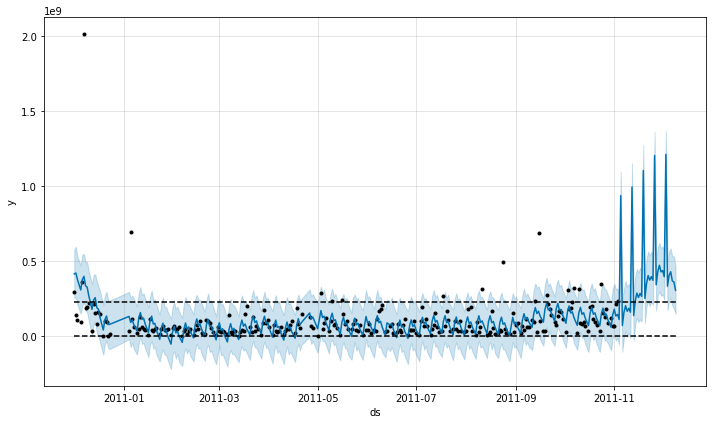

In [69]:
fig = prophet.plot(forecast)

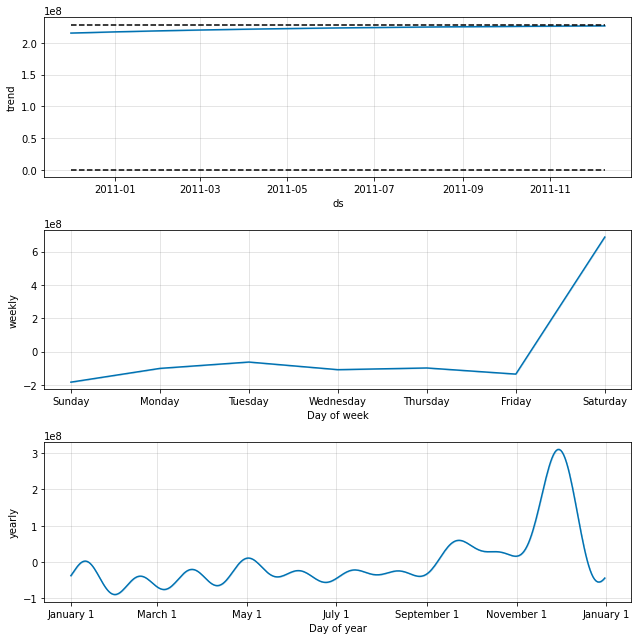

In [70]:
fig = prophet.plot_components(forecast)

#### prophet 적합5

#### holiday 파라미터
- add_country_holidays (이벤트 효과 자동입력)
- holidays (이벤트 효과 수동입력) : dataframe 형식
- holiday_prior_scale (휴일 추정 민감도) : 높을수록 민감

In [71]:
train_input['cap'] =  228837395.72125
train_input['floor'] = 0

prophet = Prophet(growth = 'logistic', 
                  changepoint_prior_scale = 0.03,
                  seasonality_mode = 'additive',
                  seasonality_prior_scale = 10,
                  yearly_seasonality = True,
                  weekly_seasonality = 'auto',
                  daily_seasonality = 'auto')

prophet.add_country_holidays(country_name = 'GB')

In [72]:
prophet.fit(train_input)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/hzov7fv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/8dlfm15f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53437', 'data', 'file=/tmp/tmpbodtrnmg/hzov7fv0.json', 'init=/tmp/tmpbodtrnmg/8dlfm15f.json', 'output', 'file=/tmp/tmpbodtrnmg/prophet_model2md3py3b/prophet_model-20230226125922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [73]:
future = prophet.make_future_dataframe(periods = 36)

In [74]:
future['cap'] =  228837395.72125
future['floor'] = 0

forecast = prophet.predict(future)

In [75]:
preds = forecast[['ds', 'yhat']][274:]
real = pp_sales[274:]
df_preds_real = pd.merge(preds, real, how = 'outer').fillna(0)

In [76]:
df_preds_real['error'] = df_preds_real['y'] - df_preds_real['yhat']
df_preds_real['error_rate'] = (np.abs(df_preds_real['error']) * 100)/df_preds_real['y']

print(np.mean(df_preds_real['error']))
print(np.mean(df_preds_real['error_rate']))

-83269606.66431576
inf


In [77]:
holidays = pd.DataFrame({'holiday' : 'holiday',
                         'ds' : pd.Series(holiday),
                         'lower_window' : 0,
                         'upper_window' : 1})

In [78]:
holidays

,holiday,ds,lower_window,upper_window
0,holiday,2010-12-04,0,1
1,holiday,2010-12-11,0,1
2,holiday,2010-12-18,0,1
3,holiday,2010-12-24,0,1
4,holiday,2010-12-25,0,1
...,...,...,...,...
64,holiday,2011-11-05,0,1
65,holiday,2011-11-12,0,1
66,holiday,2011-11-19,0,1
67,holiday,2011-11-26,0,1


In [79]:
train_input['cap'] =  228837395.72125
train_input['floor'] = 0

prophet = Prophet(growth = 'logistic', 
                  changepoint_prior_scale = 0.03,
                  seasonality_mode = 'additive',
                  seasonality_prior_scale = 10,
                  yearly_seasonality = True,
                  weekly_seasonality = 'auto',
                  daily_seasonality = 'auto',
                  holidays = holidays)

prophet.add_country_holidays(country_name = 'GB')

In [80]:
prophet.fit(train_input)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/1cofg_t8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbodtrnmg/3qzb9ttm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44012', 'data', 'file=/tmp/tmpbodtrnmg/1cofg_t8.json', 'init=/tmp/tmpbodtrnmg/3qzb9ttm.json', 'output', 'file=/tmp/tmpbodtrnmg/prophet_modelaacfbz5l/prophet_model-20230226125923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [81]:
future = prophet.make_future_dataframe(periods = 36)

In [82]:
future['cap'] =  228837395.72125
future['floor'] = 0

forecast = prophet.predict(future)

In [83]:
preds = forecast[['ds', 'yhat']][274:]
real = pp_sales[274:]
df_preds_real = pd.merge(preds, real, how = 'outer').fillna(0)

In [84]:
df_preds_real['error'] = df_preds_real['y'] - df_preds_real['yhat']
df_preds_real['error_rate'] = (np.abs(df_preds_real['error']) * 100)/df_preds_real['y']

print(np.mean(df_preds_real['error']))
print(np.mean(df_preds_real['error_rate']))

-29657371.98807806
inf


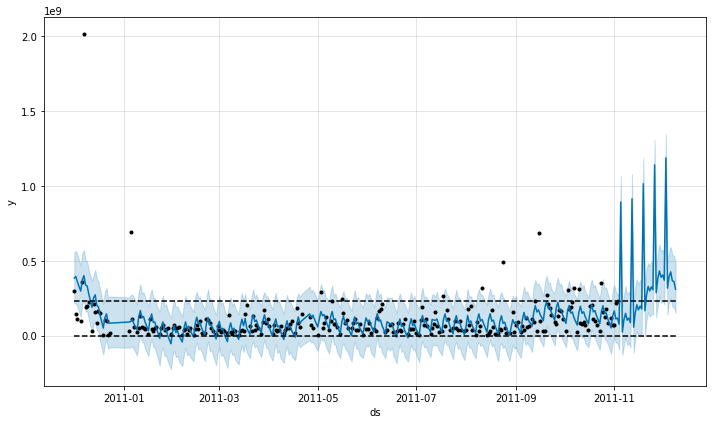

In [85]:
fig = prophet.plot(forecast)

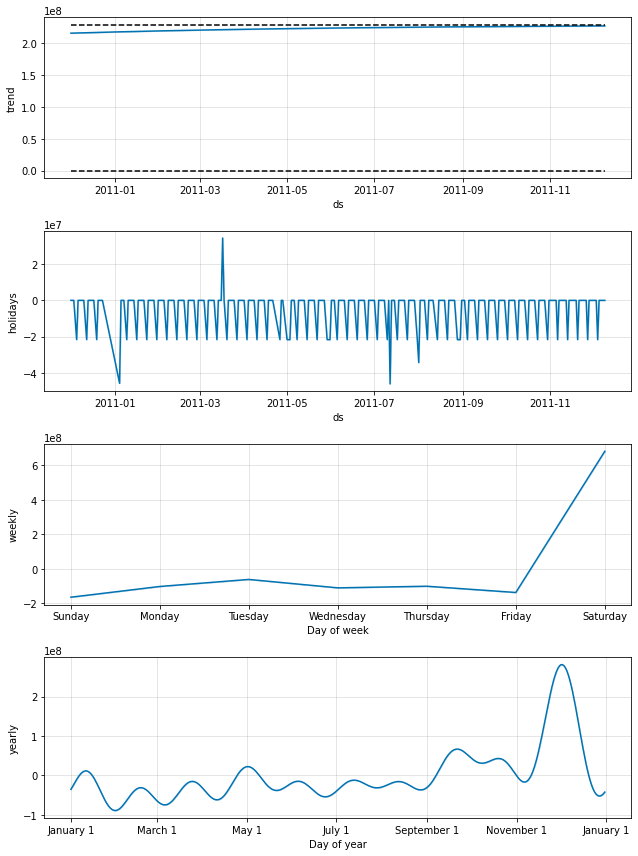

In [86]:
fig = prophet.plot_components(forecast)

In [87]:
# MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_preds_real['y'], df_preds_real['yhat'])

317103182.1523612

In [88]:
# MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(df_preds_real['y'], df_preds_real['yhat'])

2.850062057656191e+17

In [89]:
# RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_preds_real['y'], df_preds_real['yhat'])
np.sqrt(mse)

533859724.801955

#### other 파라미터
- interval_width (추세 예측 정확도 구간범위)
- mcmc_samples (계절성 예측 정확도 제어)